## Data preprocessing

### Take mini data for demo purpose

In [1]:
import pandas as pd
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.utils import shuffle


valid_metadata = "/data/tone_speech_cutwav/kaldi_cutwavs_new_2020/valid/metadata.csv"
test_metadata = "/data/tone_speech_cutwav/kaldi_cutwavs_new_2020/test/metadata.csv"

In [2]:
seed = 42
valid_df = pd.read_csv(valid_metadata)
valid_mini_df = valid_df
valid_mini_df = valid_df.sample(n=10000, replace=False, random_state=seed)
valid_mini_df = shuffle(valid_mini_df, random_state=seed)
# 確保所有label存在
# assert valid_mini_df.value_counts("label").shape[0] == 5

test_df = pd.read_csv(test_metadata)
test_mini_df = test_df
test_mini_df = test_df.sample(n=1000, replace=False, random_state=seed)
test_mini_df = shuffle(test_mini_df, random_state=seed)
# 確保所有label存在
# assert test_mini_df.value_counts("label").shape[0] == 5

In [3]:
valid_mini_df.to_csv("valid10000.csv", index=False)
test_mini_df.to_csv("test1000.csv", index=False)

In [4]:
valid_mini_df.head()

,path,label
297969,/data/tone_speech_cutwav/kaldi_cutwavs_new_202...,2
555044,/data/tone_speech_cutwav/kaldi_cutwavs_new_202...,0
195071,/data/tone_speech_cutwav/kaldi_cutwavs_new_202...,3
795283,/data/tone_speech_cutwav/kaldi_cutwavs_new_202...,0
1000486,/data/tone_speech_cutwav/kaldi_cutwavs_new_202...,0


In [5]:
num_labels = test_mini_df.value_counts("label").shape[0]
num_labels

5

In [6]:
valid_mini_df.head(), test_mini_df.head()

(                                                      path  label
 297969   /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      2
 555044   /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      0
 195071   /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      3
 795283   /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      0
 1000486  /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      0,
                                                       path  label
 5747     /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      0
 1146900  /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      3
 1085930  /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      2
 30994    /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      2
 20928    /data/tone_speech_cutwav/kaldi_cutwavs_new_202...      0)

In [7]:
valid_mini_df["label"].value_counts()

3    3262
1    2407
0    1926
2    1539
4     866
Name: label, dtype: int64

In [8]:
test_mini_df["label"].value_counts()

3    323
1    236
0    206
2    154
4     81
Name: label, dtype: int64

In [9]:
from datasets import Dataset, Audio, load_dataset

valid_dataset = Dataset.from_pandas(valid_mini_df)
test_dataset = Dataset.from_pandas(test_mini_df)

In [10]:
valid_dataset.features

{'path': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [11]:
valid_dataset = valid_dataset.remove_columns("__index_level_0__")
test_dataset = test_dataset.remove_columns("__index_level_0__")

In [12]:
valid_dataset

Dataset({
    features: ['path', 'label'],
    num_rows: 10000
})

In [13]:
char_mapping = {"<pad>": 0}
max_length_pinyin = 0
for meta in valid_dataset:
    pinyin = meta["path"].split("__pin-")[-1].split("__")[0]
    if len(pinyin) > max_length_pinyin:
        max_length_pinyin = len(pinyin)
    for char in pinyin:
        char = char.lower()
        if char not in char_mapping:
            char_mapping[char] = len(char_mapping)

print("max_length_pinyin", max_length_pinyin)
print("char_mapping", char_mapping)

max_length_pinyin 6
char_mapping {'<pad>': 0, 'w': 1, 'o': 2, 'x': 3, 'i': 4, 'n': 5, 'g': 6, 's': 7, 'h': 8, 'd': 9, 'u': 10, 'a': 11, 'f': 12, 'j': 13, 'y': 14, 'l': 15, 'z': 16, 'e': 17, 't': 18, 'm': 19, 'c': 20, 'k': 21, 'r': 22, 'b': 23, 'p': 24, 'q': 25, 'ü': 26}


In [14]:
valid_dataset[0], valid_dataset.features

({'path': '/data/tone_speech_cutwav/kaldi_cutwavs_new_2020/valid/cutwav_word_dataset009_cutok_tones/3/ds009__line-49603__ind-001__len-0.25__gop-100__rr-100__pin-wo__tone-3----wǒ.wav',
  'label': 2},
 {'path': Value(dtype='string', id=None),
  'label': Value(dtype='int64', id=None)})

In [15]:
valid_dataset.column_names

['path', 'label']

In [16]:
valid_dataset = valid_dataset.cast_column("path", Audio(sampling_rate=16000))
test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

In [17]:
from datasets import Features, Array3D

features = Features({
    **valid_dataset.features,
    "audio_arrays": Array3D(dtype="float32", shape=(3, 128, 41)),
})

In [18]:
valid_dataset.features

{'path': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'label': Value(dtype='int64', id=None)}

In [19]:
valid_dataset[0]

{'path': {'path': '/data/tone_speech_cutwav/kaldi_cutwavs_new_2020/valid/cutwav_word_dataset009_cutok_tones/3/ds009__line-49603__ind-001__len-0.25__gop-100__rr-100__pin-wo__tone-3----wǒ.wav',
  'array': array([0.00015259, 0.00036621, 0.00067139, ..., 0.01321411, 0.01324463,
         0.01293945], dtype=float32),
  'sampling_rate': 16000},
 'label': 2}

In [23]:
sampling_rate

16000

In [24]:
def waveform_to_mel(batch):
    return torchaudio.transforms.MelSpectrogram(sampling_rate, n_fft=400, n_mels=128)(batch)

def waveform_to_mfcc(batch):
    return torchaudio.transforms.MFCC(sampling_rate, n_mfcc=25)(batch)

In [26]:
channel = 0
sampling_rate = 16000
max_length = int(sampling_rate * 0.5) # 0.5秒


def prepare_dataset(batch):    
    audio_arrays = []
    for x in batch["path"]:
        if x["array"].shape[-1] < max_length:
            audio_arrays.append(np.pad(x["array"], (0,  max_length-x["array"].shape[-1]), "constant"))
            # audio_arrays.append(F.pad(torch.from_numpy(x["array"]), (0, max_length-x["array"].shape[-1])))
        else:
            # audio_arrays.append(torch.from_numpy(x["array"])[:max_length])
            audio_arrays.append(x["array"][:max_length])

    audio_arrays = np.stack(audio_arrays, axis=0)

    # tensors = torch.stack(audio_arrays)
    tensors = waveform_to_mel(torch.from_numpy(audio_arrays)).unsqueeze(1).repeat(1, 3, 1, 1)
    tensors = waveform_to_mfcc(torch.from_numpy(audio_arrays)).unsqueeze(1).repeat(1, 3, 1, 1)
    batch["audio_arrays"] = tensors.numpy()
    return batch

valid_dataset = valid_dataset.map(prepare_dataset, batched=True, batch_size=2, num_proc=1, features=features)
valid_dataset = valid_dataset.remove_columns("path")

  0%|          | 0/5000 [00:00<?, ?ba/s]

(2, 3, 128, 41)


SystemExit: 

In [149]:
# valid_dataset = valid_dataset.with_format("torch")
valid_dataset = valid_dataset.with_format("numpy")

In [150]:
type(valid_dataset[0]["audio_arrays"])

numpy.ndarray

In [151]:
valid_dataset.save_to_disk("valid10000.cache")

In [152]:
from datasets import load_from_disk

loaded_valid_dataset = load_from_disk("valid10000.cache")

In [153]:
loaded_valid_dataset[0]["audio_arrays"].shape

(3, 128, 41)

In [154]:
loaded_valid_dataset.features

{'label': Value(dtype='int64', id=None),
 'pinyin_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_arrays': Array3D(shape=(3, 128, 41), dtype='float32', id=None)}

In [155]:
loaded_valid_dataset.shape

(10000, 3)

In [156]:
from torch.utils.data import Dataset

class ToneDataset(Dataset):
    def __init__(self, dataset):
        self.ds = dataset

    def __len__(self):
        return self.ds.shape[0]

    def __getitem__(self,idx):
        return self.ds[idx]["audio_arrays"], self.ds[idx]["label"], self.ds[idx]["pinyin_ids"]

In [157]:
td = ToneDataset(loaded_valid_dataset)

In [158]:
valid_dataloader = torch.utils.data.DataLoader(td, batch_size=512, pin_memory=False)

In [222]:
mels, labels, ids = next(iter(valid_dataloader))
ids.shape

torch.Size([512, 6])

## Build Dataset and Dataloader

In [164]:
print("num of batch:", len(valid_dataloader))

num of batch: 20


In [166]:
mels.shape

torch.Size([512, 3, 128, 41])

## Build model

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [206]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True, padding_idx=0)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [207]:
len(char_mapping), torch.flatten(ids)[:18]

(27, tensor([1, 2, 0, 0, 0, 0, 3, 4, 5, 6, 0, 0, 7, 8, 4, 0, 0, 0]))

In [208]:
text_model = TextClassificationModel(vocab_size=len(char_mapping), embed_dim=4, num_class=5)

# ids = torch.flatten(ids)
# offsets = torch.tensor(list(range(0, len(ids), 6)))

In [209]:
# text_model(ids, offsets=offsets)

tensor([[ 0.1645,  0.0064,  0.0301,  0.1418, -0.1266],
        [-0.0623,  0.0494, -0.0706, -0.0265, -0.0162],
        [ 0.0650,  0.0112, -0.0672,  0.0592, -0.1478],
        ...,
        [ 0.0060,  0.0453, -0.0562,  0.0454, -0.0582],
        [-0.0759,  0.0959, -0.1619,  0.0501, -0.0718],
        [-0.1155, -0.0486, -0.0402, -0.0985,  0.0704]],
       grad_fn=<AddmmBackward0>)

In [211]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12992, 50)
        self.fc2 = nn.Linear(50, num_labels)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return x

In [229]:
class CustomTextCNN(nn.Module):
    def __init__(self, vocab_size, text_embed_dim, num_class=5):
        super().__init__()
        self.cnn = CNNet()
        self.text_model = TextClassificationModel(vocab_size=vocab_size, embed_dim=text_embed_dim, num_class=num_class)
        self.text_norm = nn.LayerNorm(num_class)
        self.cnn_norm = nn.LayerNorm(num_class)
        self.fc = nn.Linear(5, 5)

    def forward(self, audio_arrays, ids, offsets):
        cnn_logits = self.cnn(audio_arrays)
        text_logits = self.text_model(ids, offsets=offsets)
        cnn_logits = F.dropout(self.cnn_norm(cnn_logits), training=self.training)
        text_logits = F.dropout(self.text_norm(text_logits), training=self.training)
        x = F.relu(self.fc(cnn_logits + text_logits))
        return x

In [230]:
device = "cuda"
model = CustomTextCNN(len(char_mapping), text_embed_dim=4).to(device)
ids = torch.flatten(ids)
offsets = torch.tensor(list(range(0, len(ids), 6)))

with torch.no_grad():
    out = model(mels.to(device), ids.to(device), offsets.to(device))

In [232]:
out.shape, out

(torch.Size([512, 5]),
 tensor([[2.4251, 1.8390, 2.4724, 0.5134, 0.0000],
         [0.1095, 0.2833, 0.0000, 1.0244, 0.0000],
         [1.7786, 0.1817, 1.0451, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0334, 0.6131, 0.5267, 0.4194],
         [0.0000, 0.0000, 0.1205, 0.6587, 0.0000],
         [0.5025, 2.1733, 2.6778, 0.0000, 0.5759]], device='cuda:0'))

## Train and test

In [66]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0

    for batch, (X, Y) in tqdm(enumerate(dataloader)):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    # print(f'\nTrain:\nacc: {(100*correct):>0.1f}%, avg loss: {train_loss:>8f}\n')
    return train_loss, correct


# Create the validation/test function
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in tqdm(enumerate(dataloader)):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    # print(f'\nTest:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')
    return test_loss, correct

In [67]:
print("valid num_batch:", len(valid_dataloader.dataset))
print("test num_batch:", len(test_dataloader.dataset))

valid num_batch: 10000
test num_batch: 1000


In [68]:
epochs = 1
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for _ in range(epochs):
    train_loss, train_correct = train(valid_dataloader, model, cost, optimizer)
    test_loss, test_correct = test(test_dataloader, model)
    train_losses.append(train_loss)
    train_acc.append(train_correct)
    val_losses.append(test_loss)
    val_acc.append(test_correct)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

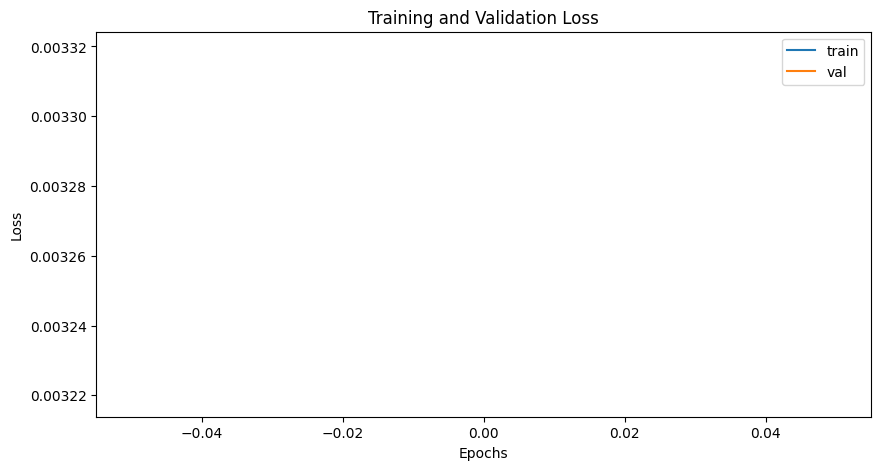

In [69]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

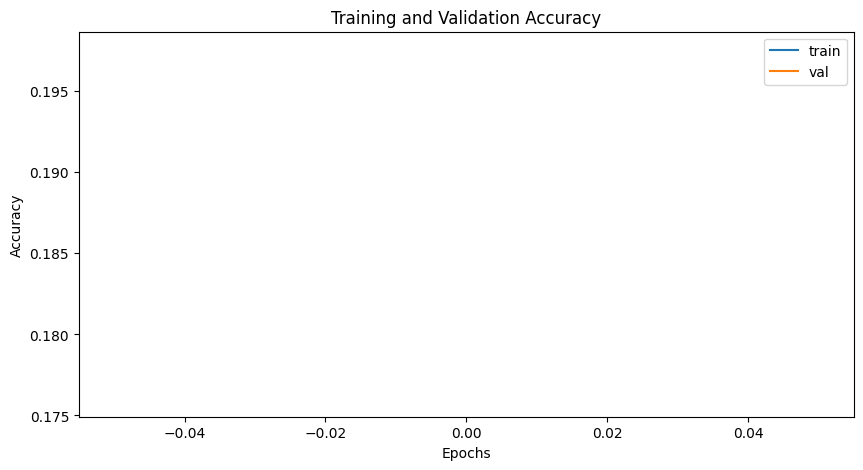

In [70]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc,label="train")
plt.plot(val_acc,label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [71]:
train_acc

[0.1976]

In [80]:
model.eval()
predict = []
labels = []
with torch.no_grad():
    for X, Y in test_dataloader:
        X = X.to(device)
        pred = model(X)
        predict.extend(pred.argmax(1).tolist())
        labels.extend(Y.tolist())

/home/vincent0730/ML_chinese_tone_classification/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


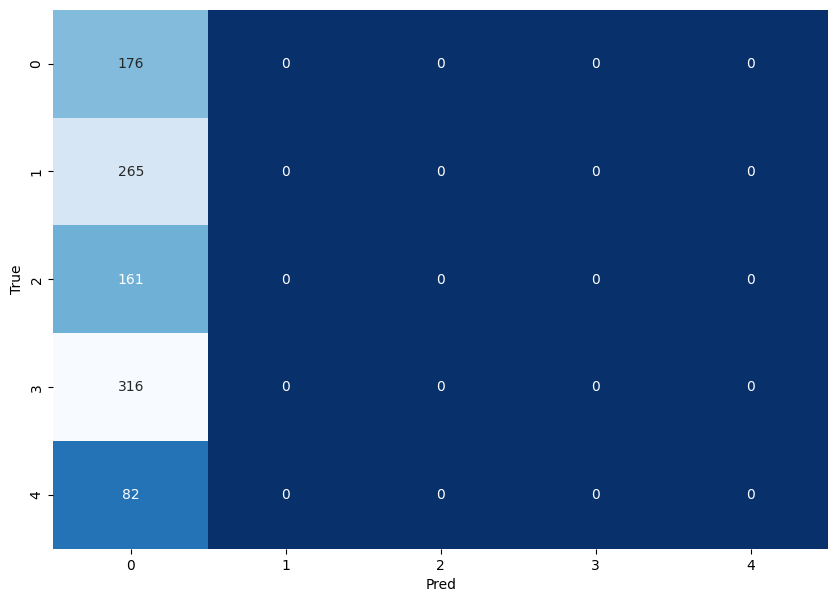

: 

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


# confusion matrix
df = pd.DataFrame({"tone": labels, "predict": predict})
array = confusion_matrix(df["tone"], df["predict"])
cf_arrays = [array]

for array in cf_arrays:
    df_cm = (pd.DataFrame(array, index=["0", "1", "2", "3", "4"], columns=["0", "1", "2", "3", "4"]),)
    fig1 = plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm[0], annot=True, cmap="Blues_r", fmt="d", cbar=False)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")